In [1]:
# %% [markdown]
### Cell 1: Imports and Configuration
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json
import os
import matplotlib.pyplot as plt
from Get_Go_Emo import get_go
from Get_Isear import get_isr

In [2]:
# Updated Configuration
NUM_SAMPLES = 1000
LEARNING_RATE = 1e-3  # Increased from 3e-4
BATCH_SIZE = 16      # Reduced from 256
DROPOUT_RATE = 0.3    # Reduced from 0.5     
EPOCHS = 5          # Increased from 200
HIDDEN_LAYER_CONFIGS = [
    [], 
    [256], 
    [512, 256], 
    [512, 256, 128],
    [1024, 512, 256, 128]  # Added deeper config
]
WEIGHT_DECAY = 1e-4
PATIENCE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LOG_PATH = "probe_logs/mlp_trials.json"

In [3]:
def recursive_flatten(x):
    """Recursively flatten nested lists/tuples."""
    if isinstance(x, (list, tuple)):
        return [item for sublist in x for item in recursive_flatten(sublist)]
    return [x]

def pad_or_truncate(arr, target_length):
    """Ensure array reaches target length."""
    if len(arr) > target_length:
        return arr[:target_length]
    elif len(arr) < target_length:
        return np.pad(arr, (0, target_length - len(arr)))
    return arr

def enhanced_safe_float_array(x, expected_length=None):
    """Convert x (which may be nested) into a flattened np.array of dtype float32.
       Also applies padding or truncation if expected_length is provided."""
    try:
        # Try a direct conversion first:
        arr = np.array(x, dtype=np.float32).flatten()
    except Exception as e:
        print(f"Direct conversion failed: {e}. Using recursive flattening.")
        flat = recursive_flatten(x)
        # If the elements are strings, convert them:
        if flat and isinstance(flat[0], str):
            flat = [float(item) for item in flat]
        arr = np.array(flat, dtype=np.float32).flatten()

    if expected_length is not None:
        if len(arr) > expected_length:
            arr = arr[:expected_length]
        elif len(arr) < expected_length:
            arr = np.pad(arr, (0, expected_length - len(arr)))
    return arr.astype(np.float32)

def validate_array(arr, expected_length=None):
    """Print diagnostics about the array and check for NaNs and dimension matches."""
    if np.any(np.isnan(arr)):
        print("Warning: Array contains NaN values")
    if expected_length and len(arr) != expected_length:
        print(f"Array length mismatch: {len(arr)} vs {expected_length}")
    print(f"Array stats -> min: {np.min(arr)}, max: {np.max(arr)}, mean: {np.mean(arr)}, std: {np.std(arr)}")
    return True

In [4]:
def process_hidden_states(df, model_type):
    """Process layer columns directly into numpy arrays with debugging.
    Converts string representations if needed and ensures fixed lengths."""
    processed = []
    layer_cols = [col for col in df.columns if col.startswith('layer_')]
    
    print(f"Processing hidden states: Detected layers: {layer_cols}")
    
    for idx, row in df.iterrows():
        layer_dict = {}
        for layer in layer_cols:
            values = row[layer]
            # Convert from string if necessary
            if isinstance(values, str):
                try:
                    values = json.loads(values)
                except Exception as e:
                    print(f"Row {idx} layer {layer}: JSON load failed, trying eval: {e}")
                    values = eval(values)
            # Convert to numpy array
            arr = np.array(recursive_flatten(values), dtype=np.float32)
            
            # Fixed length: 768 for BERT, 1280 for GPT-2
            target_length = 768 if 'bert' in model_type else 1280
            arr = pad_or_truncate(arr, target_length)
            # Optionally validate each array
            # validate_array(arr, expected_length=target_length)
            
            layer_dict[layer] = arr
        processed.append(layer_dict)
    
    # Print out structure of first sample for debugging:
    print("Sample hidden states (first sample):")
    first_sample = processed[0]
    for layer, arr in first_sample.items():
        print(f"  {layer}: shape {arr.shape}, dtype {arr.dtype}")
    
    return pd.DataFrame(processed)

def load_hidden_states(path, model_type):
    """Load hidden states from JSON and process them."""
    print(f"Loading hidden states from: {path}")
    df = pd.read_json(path, orient='records')
    return process_hidden_states(df, model_type)

In [5]:
# Load hidden states with model type identifiers
bert_goEmo_hidden = load_hidden_states(
    'hidden_states/bert-base-uncased_goEmo.json', 'bert'
)
bert_isear_hidden = load_hidden_states(
    'hidden_states/bert-base-uncased_isear.json', 'bert'
)
gpt2_goEmo_hidden = load_hidden_states(
    'hidden_states/gpt2_goEmo.json', 'gpt2'
)
gpt2_isear_hidden = load_hidden_states(
    'hidden_states/gpt2_isear.json', 'gpt2'
)

print("Hidden states shapes:")
print("BERT GoEmo:", bert_goEmo_hidden.shape)
print("BERT ISEAR:", bert_isear_hidden.shape)
print("GPT2 GoEmo:", gpt2_goEmo_hidden.shape)
print("GPT2 ISEAR:", gpt2_isear_hidden.shape)

# Load labels
goemo_data = get_go()[:NUM_SAMPLES]
isear_data = get_isr()[:NUM_SAMPLES]

# Create dataset structure
model_datasets = {
    'bert-base-uncased': {
        'GoEmo': {'hidden_states': bert_goEmo_hidden, 'data': goemo_data, 'multilabel': True},
        'ISEAR': {'hidden_states': bert_isear_hidden, 'data': isear_data, 'multilabel': False}
    },
    'gpt2': {
        'GoEmo': {'hidden_states': gpt2_goEmo_hidden, 'data': goemo_data, 'multilabel': True},
        'ISEAR': {'hidden_states': gpt2_isear_hidden, 'data': isear_data, 'multilabel': False}
    }
}

Loading hidden states from: hidden_states/bert-base-uncased_goEmo.json


Processing hidden states: Detected layers: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12']
Sample hidden states (first sample):
  layer_0: shape (768,), dtype float32
  layer_1: shape (768,), dtype float32
  layer_2: shape (768,), dtype float32
  layer_3: shape (768,), dtype float32
  layer_4: shape (768,), dtype float32
  layer_5: shape (768,), dtype float32
  layer_6: shape (768,), dtype float32
  layer_7: shape (768,), dtype float32
  layer_8: shape (768,), dtype float32
  layer_9: shape (768,), dtype float32
  layer_10: shape (768,), dtype float32
  layer_11: shape (768,), dtype float32
  layer_12: shape (768,), dtype float32
Loading hidden states from: hidden_states/bert-base-uncased_isear.json
Processing hidden states: Detected layers: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12']
Sa

In [6]:
def process_labels(labels, multilabel=False):
    """Convert labels to the proper format.
    For multilabel, returns a multi-hot encoded array for 28 classes.
    For single-label (ISEAR), returns a zero-indexed integer array."""
    if multilabel:
        num_classes = 28
        multi_hot = np.zeros((len(labels), num_classes), dtype=np.float32)
        for i, lbl_str in enumerate(labels):
            clean_str = lbl_str.strip('[]')
            lbl_list = list(map(int, clean_str.split()))
            for lbl in lbl_list:
                if lbl < num_classes:
                    multi_hot[i, lbl] = 1.0
        return multi_hot
    else:
        # For ISEAR labels, expect numbers (as string or int). Convert to zero-indexed.
        processed = []
        for lbl in labels:
            if isinstance(lbl, str):
                processed.append(int(lbl.strip()) - 1)
            else:
                processed.append(int(lbl) - 1)
        return np.array(processed, dtype=np.int64)

In [7]:
class MLPProbe(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, multilabel=False, dropout_rate=0.5):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        for i in range(len(dims)-1):
            layers.extend([
                nn.Linear(dims[i], dims[i+1]),
                nn.BatchNorm1d(dims[i+1]),
                nn.GELU(),
                nn.Dropout(dropout_rate)
            ])
            
        layers.append(nn.Linear(dims[-1], num_classes))
        self.model = nn.Sequential(*layers)
        self.multilabel = multilabel
        
        # Proper weight initialization
        self._init_weights()
        
    def _init_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
                    
    def forward(self, x):
        return self.model(x)
    
# Calculate weights based on label frequency
def calculate_class_weights(labels, multilabel):
    if multilabel:
        pos_counts = np.sum(labels, axis=0)
        pos_weights = (len(labels) - pos_counts) / (pos_counts + 1e-7)
        return torch.tensor(pos_weights, dtype=torch.float32).to(DEVICE)
    else:
        class_counts = np.bincount(labels)
        class_weights = 1. / (class_counts + 1e-7)
        return torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

def train_probe(X_train, y_train, input_dim, num_classes, hidden_dims, multilabel=False, loss_type='bce'):
    model = MLPProbe(input_dim, hidden_dims, num_classes, multilabel).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    

    
    if not torch.cuda.is_available() and DEVICE == 'cuda':
        print("Warning: CUDA not available, using CPU")

    # Determine target dtype based on loss type
    if multilabel:
        target_dtype = torch.float32
        pos_weights = calculate_class_weights(y_train, multilabel=True)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    else:
        if loss_type == 'hinge':
            target_dtype = torch.long
            criterion = nn.MultiMarginLoss()
        else:
            target_dtype = torch.long
            class_weights = calculate_class_weights(y_train, multilabel=False)
            criterion = nn.CrossEntropyLoss(weight=class_weights)
        
    # Normalization using training data
    X_train_np = np.array(X_train)
    mean = np.mean(X_train_np, axis=0)
    std = np.std(X_train_np, axis=0) + 1e-8
    X_train_norm = (X_train_np - mean) / std

    # Create dataset with aggressive augmentation
    # Create dataset with correct dtypes
    dataset = TensorDataset(
        torch.tensor(X_train_norm, dtype=torch.float32),
        torch.tensor(y_train, dtype=target_dtype)
    )
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

    # Training with early stopping
    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            optimizer.zero_grad(set_to_none=True)
            preds = model(X_batch)
            
            if multilabel:
                loss = criterion(preds, y_batch)
            else:
                if loss_type == 'hinge':
                    # Convert labels to class indices for hinge loss
                    loss = criterion(preds, y_batch)
                else:
                    loss = criterion(preds, y_batch)
                    
                    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            

                    
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        scheduler.step(avg_loss)
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

    return model, mean, std

def evaluate_probe(model, X_test, y_test, mean, std, multilabel=False):
    """Evaluate with proper normalization and metrics"""
    model.eval()
    with torch.no_grad():
        X_test_norm = (X_test - mean) / std
        X_tensor = torch.tensor(X_test_norm, dtype=torch.float32).to(DEVICE)
        y_tensor = torch.tensor(y_test, dtype=torch.float32 if multilabel else torch.long).to(DEVICE)
        
        preds = model(X_tensor)
        results = {}

        if multilabel:
            # Multi-label evaluation
            preds = torch.sigmoid(preds)
            preds_bin = (preds > 0.5).float()
            
            results['per_label_acc'] = (preds_bin == y_tensor).float().mean().item()
            results['exact_acc'] = (preds_bin == y_tensor).all(dim=1).float().mean().item()
            results['hamming_loss'] = ((preds_bin != y_tensor).float().sum(dim=1).mean() / y_tensor.shape[1]).item()
            
            print(f"Exact: {results['exact_acc']:.4f} | Labels: {results['per_label_acc']:.4f} | Hamming: {results['hamming_loss']:.4f}")
        else:
            # SINGLE-LABEL FIX: Calculate before printing
            _, predicted = torch.max(preds, 1)
            results['exact_acc'] = accuracy_score(y_tensor.cpu().numpy(), predicted.cpu().numpy())
            print(f"Accuracy: {results['exact_acc']:.4f}")

        return results

In [8]:
# ====================================================
# Training Probes for Each Dataset
# ====================================================
def train_probes_for_dataset(model_name, dataset_name, data_dict):
    """Full training pipeline (with debugging) for one model-dataset combination."""
    print(f"\n=== Training {model_name} on {dataset_name} ===")
    results = {}
    
    # Load and process labels
    df = data_dict['hidden_states']
    labels = process_labels(data_dict['data']['labels'], data_dict['multilabel'])
    print(f"First 5 processed labels: {labels[:5]}")
    
    layers = [col for col in df.columns if col.startswith('layer_')]
    print(f"Layers detected in hidden states: {layers}")
    
    # Split data indices once per dataset; use stratification if possible
    idxs = np.arange(len(labels))
    stratify = labels if not data_dict['multilabel'] else None
    train_idx, test_idx = train_test_split(idxs, test_size=0.2, stratify=stratify)
    
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    print(f"Train/Test size: {len(y_train)}/{len(y_test)}")
    
    for layer in layers:
        try:
            X = np.stack(df[layer].values)
            X_train, X_test = X[train_idx], X[test_idx]
            
            for depth in HIDDEN_LAYER_CONFIGS:
                # Train with returned normalization stats
                probe_model, mean, std = train_probe(
                    X_train, y_train,
                    input_dim=X.shape[1],
                    num_classes=(28 if data_dict['multilabel'] else 7),
                    hidden_dims=depth,
                    multilabel=data_dict['multilabel']
                )
                
                # Evaluate with proper normalization
                eval_results = evaluate_probe(
                    probe_model, X_test, y_test,
                    mean, std,  # Pass normalization stats
                    data_dict['multilabel']
                )
                
                # Store both metrics
                key = f"{layer}_{len(depth)}HL"
                results[key] = {
                    'acc': eval_results['exact_acc'],
                    'hamming': eval_results.get('hamming_loss', None)
                }
                
        except Exception as e:
            print(f"Error in {layer}: {e}")
            continue
            
    return results

In [9]:
# Loop over all model-dataset combinations
all_results = {}
for model_name, datasets in model_datasets.items():
    for ds_name, ds_data in datasets.items():
        print(f"\n>>> Starting training for {model_name} on {ds_name}")
        res = train_probes_for_dataset(model_name, ds_name, ds_data)
        all_results[f"{model_name} | {ds_name}"] = res
        print(f"Completed {model_name} - {ds_name}")
        print("Results:", res)


>>> Starting training for bert-base-uncased on GoEmo

=== Training bert-base-uncased on GoEmo ===
First 5 processed labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Layers detected in hidden states: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12']
Train/Test size: 800/200
Exact: 0.0000 | Labels: 0.6607 | Hamming: 0.3393
Early stopping at epoch 19
Exact: 0.0000 | Labels: 0.4264 | Hamming: 0.5736
Early stopping at epoch 10
Exact: 0.0000 | Labels: 0.7607 | Hamming: 0.2393
Early stopping at epoc

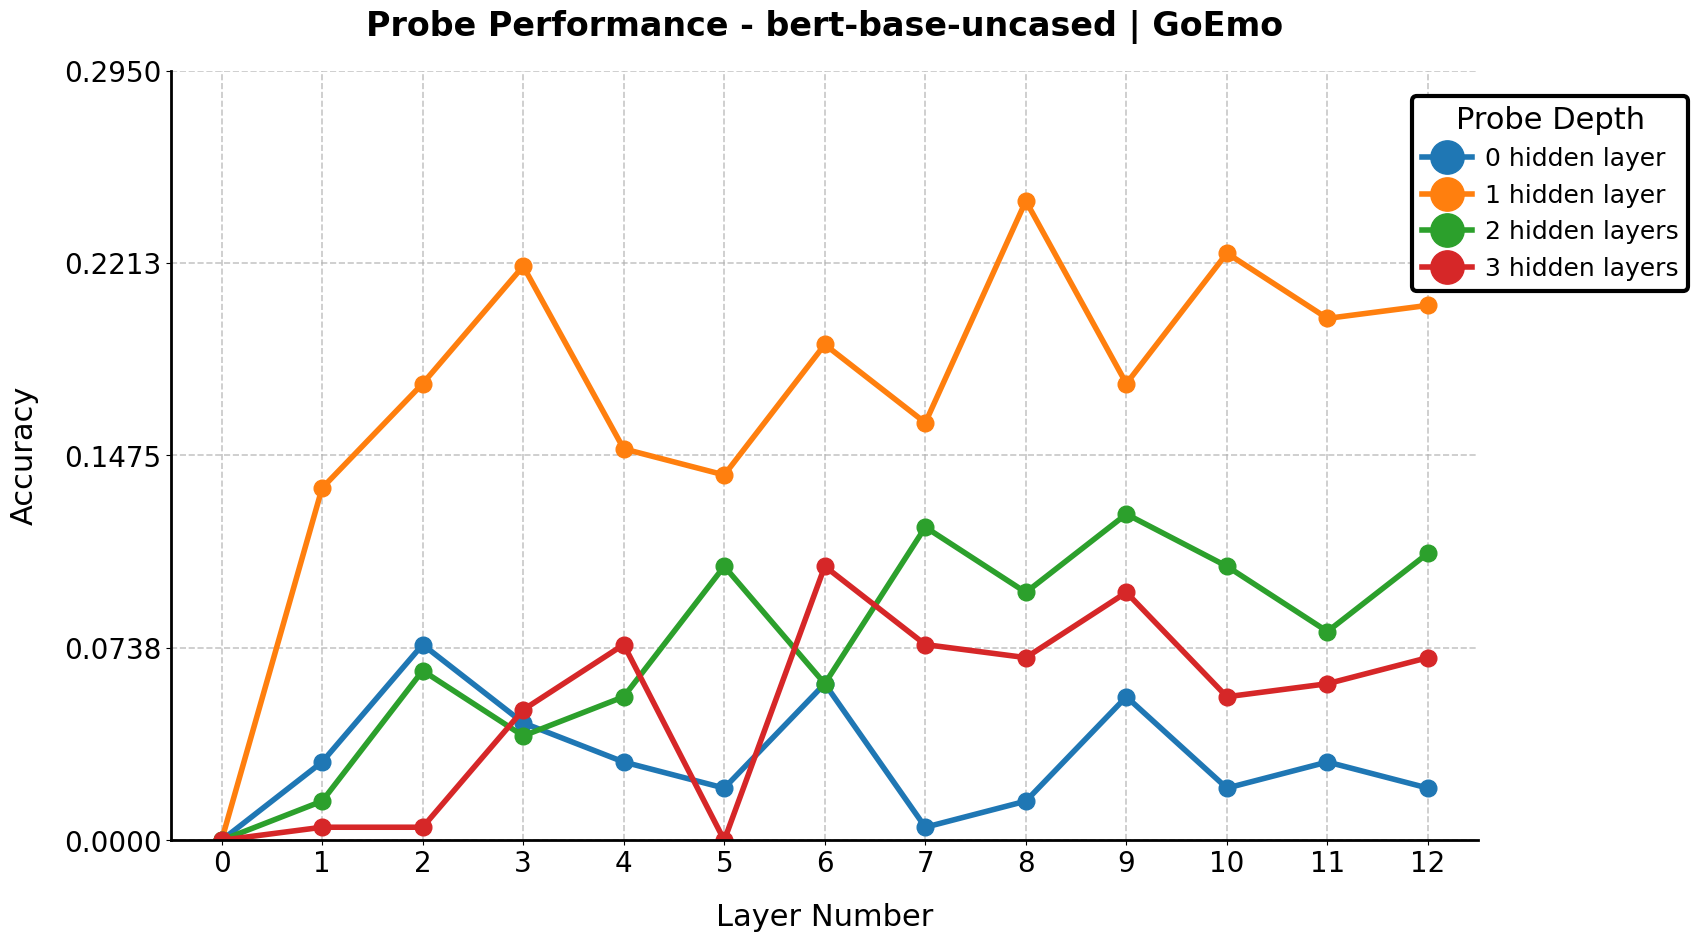

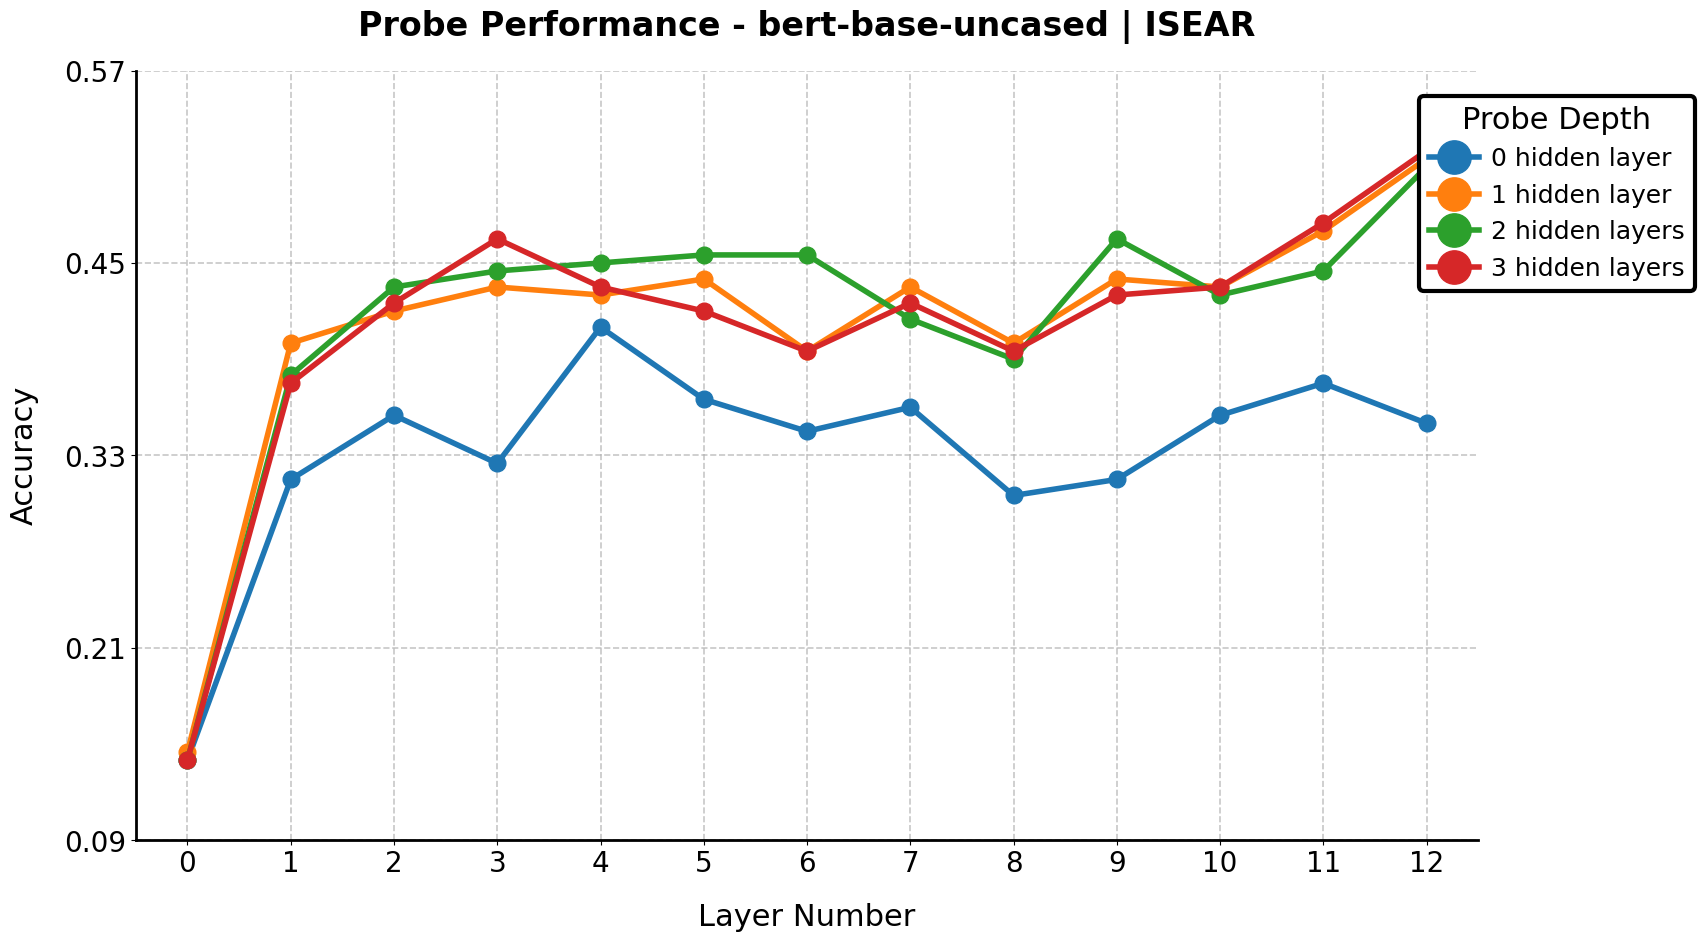

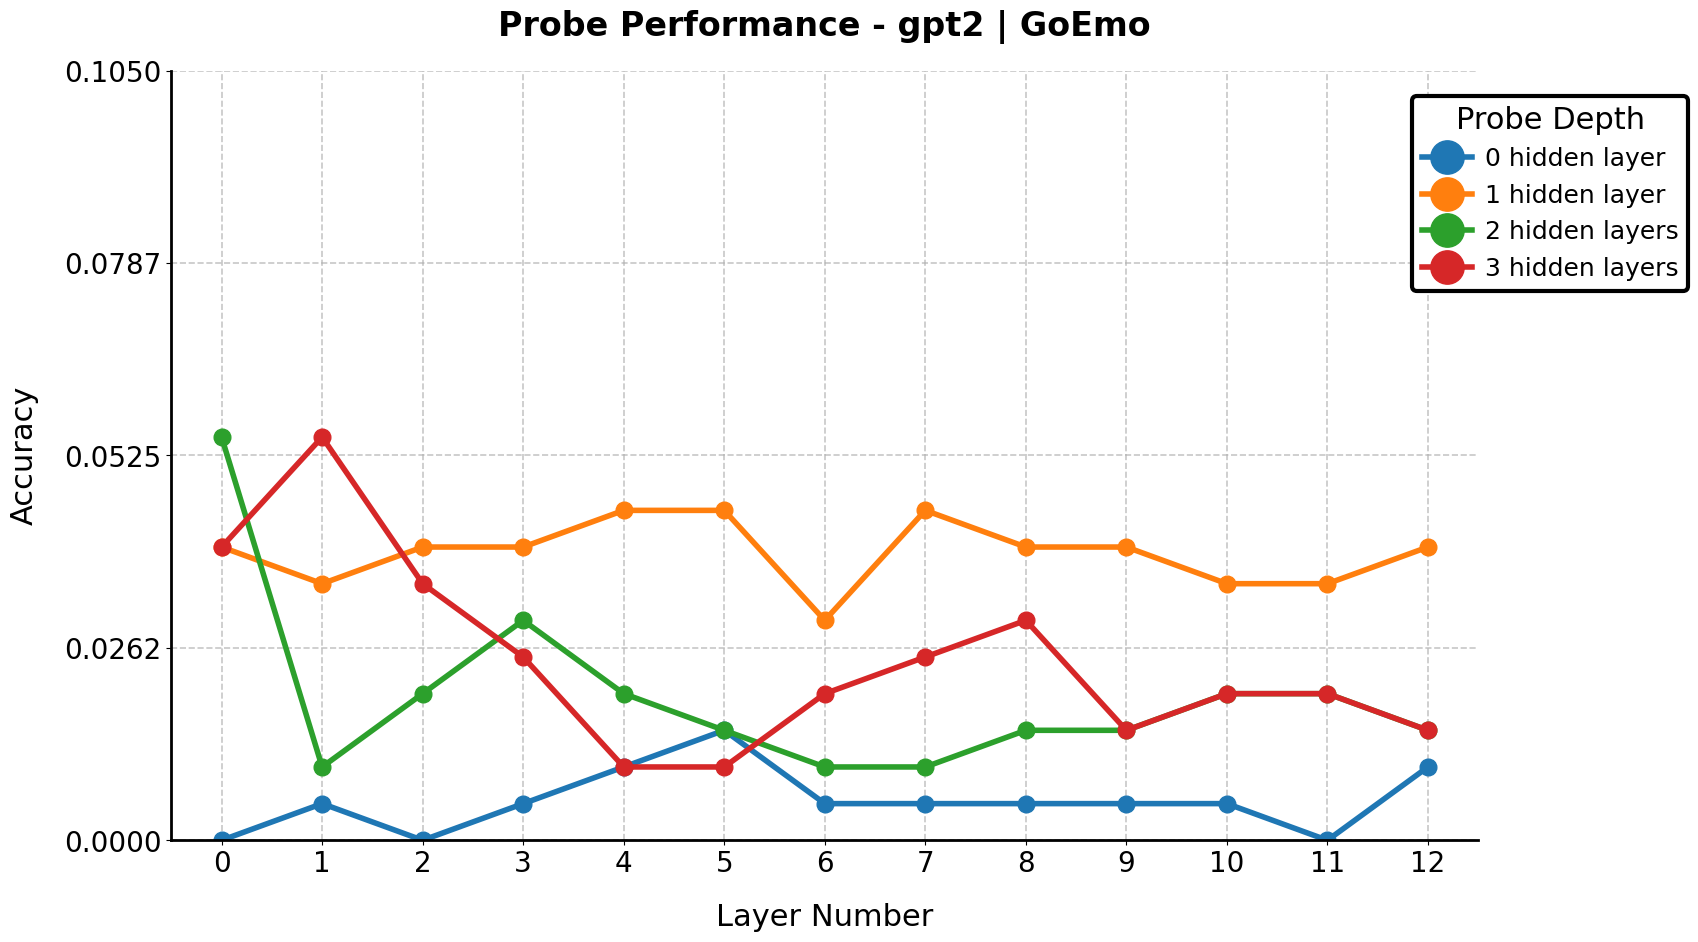

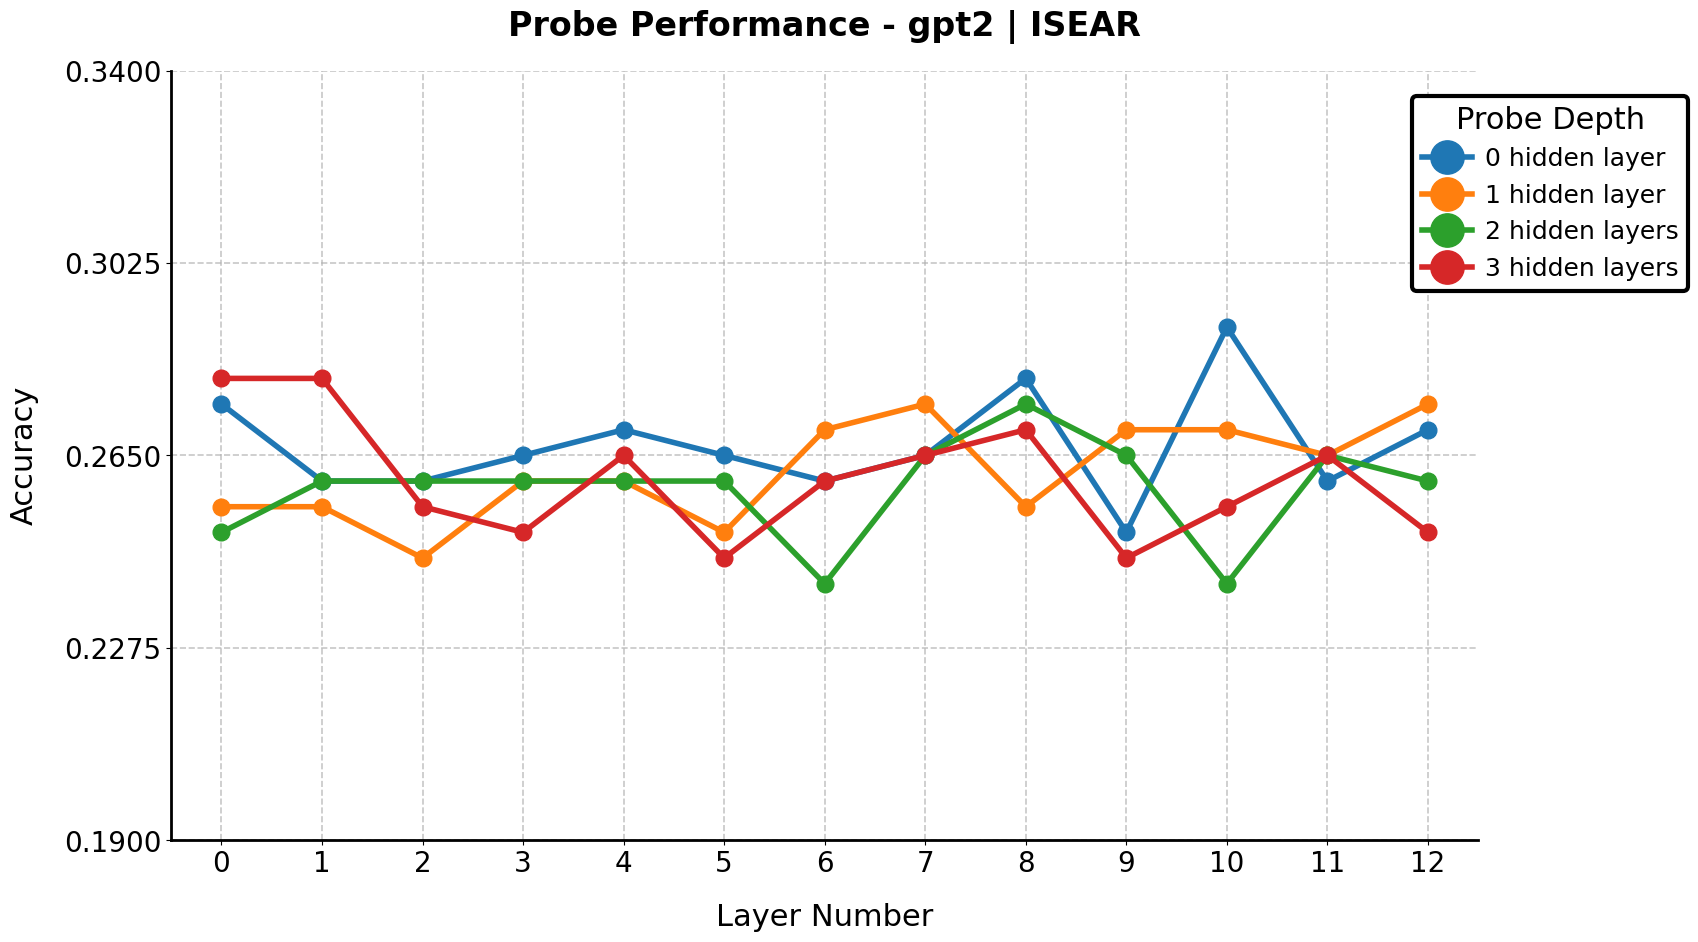

In [16]:
# ====================================================
# Plotting Results
# ====================================================
def plot_results(results_dict):
    for model_ds, res in results_dict.items():
        layers_dict = {}
        all_depths = set()
        all_acc = []  # To collect all accuracy values
        
        # First pass to collect data and metrics
        for key, metrics in res.items():
            try:
                parts = key.split('_')
                if len(parts) < 3:
                    continue
                layer_num = int(parts[1])
                depth = int(parts[2].replace('HL',''))
                all_depths.add(depth)
                
                if layer_num not in layers_dict:
                    layers_dict[layer_num] = {}
                
                acc_value = metrics['acc']
                layers_dict[layer_num][depth] = acc_value
                all_acc.append(acc_value)
                
            except Exception as e:
                print(f"Skipping key {key}: {e}")
                continue
        
        if not all_acc:
            print(f"No valid data for {model_ds}, skipping.")
            continue
        
        # Calculate y-axis limits with padding
        min_acc = min(all_acc)
        max_acc = max(all_acc)
        padding = 0.05
        y_min = max(0, min_acc - padding)
        y_max = min(1, max_acc + padding)
        
        ordered_layers = sorted(layers_dict.keys())
        ordered_depths = sorted(all_depths)
        x = np.array(ordered_layers)
        
        # Configure plot aesthetics
        plt.figure(figsize=(20, 12))  # Increased vertical size
        plt.rcParams.update({
            'font.size': 20,
            'axes.titlesize': 24,
            'axes.labelsize': 22,
            'xtick.labelsize': 20,
            'ytick.labelsize': 20,
            'legend.fontsize': 18,
            'legend.title_fontsize': 22
        })
        
        # Plot each depth series
        for depth in ordered_depths:
            y_vals = []
            for layer in ordered_layers:
                y_vals.append(layers_dict[layer].get(depth, np.nan))
            plt.plot(x, y_vals, marker='o', markersize=12, linewidth=4,
                     label=f"{depth} hidden layer{'s' if depth > 1 else ''}")

        # Styling and labels
        plt.title(f"Probe Performance - {model_ds}", pad=25, fontweight='bold')
        plt.xlabel("Layer Number", labelpad=18)
        plt.ylabel("Accuracy", labelpad=18)
        
        # Axis configuration
        plt.xticks(x, fontsize=20)
        plt.yticks(np.linspace(y_min, y_max, 5), fontsize=20)  # Ensure 5 ticks
        plt.grid(True, linestyle='--', alpha=0.7, linewidth=1.2)
        
        # Enhanced legend
        legend = plt.legend(title="Probe Depth", 
                          loc='upper right',
                          bbox_to_anchor=(1.18, 1),  # More space for text
                          markerscale=2,  # Larger legend markers
                          handletextpad=0.5,  # Space between marker and text
                          framealpha=1,
                          edgecolor='black',
                          borderaxespad=1)
        legend.get_frame().set_linewidth(3)  # Thicker border
        
        # Axis limits and styling
        plt.ylim(y_min, y_max)
        plt.xlim(min(x)-0.5, max(x)+0.5)
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['left'].set_linewidth(2)
        plt.gca().spines['bottom'].set_linewidth(2)
        
        # Final layout adjustments
        plt.tight_layout(pad=5)
        plt.show()
plot_results(all_results)

In [11]:
# ====================================================
# Save Results Log
# ====================================================
def log_trial_result(log_path, log_data):
    """Append trial log data to a JSON file."""
    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            logs = json.load(f)
    else:
        logs = []
    logs.append(log_data)
    with open(log_path, 'w') as f:
        json.dump(logs, f, indent=2)
    print(f"Logged trial: {log_data}")

In [12]:
# Save the final results log
os.makedirs(os.path.dirname(LOG_PATH), exist_ok=True)
with open(LOG_PATH, 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"Results saved to {LOG_PATH}")


Results saved to probe_logs/mlp_trials.json


### Why are the accuracies of the probes better with ISEAR than with Go Emotion ?!

In [13]:

import json
import os
from datetime import datetime
import itertools
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm


In [14]:
class HyperparameterTuner:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.results = []
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Full hyperparameter grid
        self.hparam_grid = {
            'learning_rate': [1e-3, 3e-4, 1e-4],
            'dropout_rate': [0.3, 0.5, 0.7],
            'batch_size': [64, 128, 256],
            'weight_decay': [0, 1e-4, 1e-3],
            'epochs': [50, 100, 150],
            'hidden_configs': [[], [512], [512, 256], [512, 256, 128]],
            'loss_functions': {
                'multilabel': ['bce', 'focal', 'hinge'],
                'singlelabel': ['ce', 'focal', 'hinge']
            }
        }
        
    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.reduction = reduction

        def forward(self, inputs, targets):
            bce_loss = nn.functional.binary_cross_entropy_with_logits(
                inputs, targets, reduction='none'
            )
            pt = torch.exp(-bce_loss)
            focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
            
            if self.reduction == 'mean':
                return focal_loss.mean()
            elif self.reduction == 'sum':
                return focal_loss.sum()
            return focal_loss

    def get_criterion(self, loss_type, multilabel):
        if multilabel:
            if loss_type == 'hinge':
                raise ValueError("Hinge loss not supported for multi-label tasks")
            elif loss_type == 'bce':
                return nn.BCEWithLogitsLoss()
            elif loss_type == 'focal':
                return self.FocalLoss()
        else:
            if loss_type == 'ce':
                return nn.CrossEntropyLoss()
            elif loss_type == 'focal':
                return self.FocalLoss()
            elif loss_type == 'hinge':
                return nn.MultiMarginLoss()
        raise ValueError(f"Invalid loss type: {loss_type}")

    def tune(self, X, y, input_dim, num_classes, multilabel, num_samples=100):
        combos = list(itertools.product(
            self.hparam_grid['learning_rate'],
            self.hparam_grid['dropout_rate'],
            self.hparam_grid['batch_size'],
            self.hparam_grid['weight_decay'],
            self.hparam_grid['epochs'],
            self.hparam_grid['hidden_configs'],
            self.hparam_grid['loss_functions']['multilabel' if multilabel else 'singlelabel']  # Correct key
        ))
        
        pbar = tqdm(combos, desc="Hyperparameter Tuning")
        for lr, dropout, bs, wd, epochs, hidden, loss_fn in pbar:
            try:
                model = self.train_model(
                    X[:num_samples], y[:num_samples],  # Use subset for quick testing
                    input_dim, num_classes, multilabel,
                    hidden, dropout, lr, wd, bs, epochs, loss_fn
                )
                metrics = self.evaluate_model(model, X, y, multilabel)
                
                self.results.append({
                    'timestamp': self.timestamp,
                    'params': {
                        'learning_rate': lr,
                        'dropout_rate': dropout,
                        'batch_size': bs,
                        'weight_decay': wd,
                        'epochs': epochs,
                        'hidden_layers': hidden,
                        'loss_function': loss_fn
                    },
                    'metrics': metrics
                })
                
                self.save_results()
                pbar.set_postfix_str(f"Current Best: {self.get_best_score(multilabel)}")
            except Exception as e:
                print(f"Failed combo {lr}-{dropout}-{bs}-{wd}-{epochs}-{hidden}-{loss_fn}: {str(e)}")

    def train_model(self, X_train, y_train, input_dim, num_classes, multilabel,
                   hidden_layers, dropout, lr, wd, bs, epochs, loss_fn):
        model = MLPProbe(
            input_dim=input_dim,
            hidden_dims=hidden_layers,
            num_classes=num_classes,
            multilabel=multilabel,
            dropout_rate=dropout
        ).to(self.device)
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        criterion = self.get_criterion(loss_fn, multilabel)
        
        if multilabel:
            target_dtype = torch.float32
        else:
            target_dtype = torch.long

        dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=target_dtype)  # Cast targets here
        )
        loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
        
        model.train()
        for _ in range(epochs):
            for inputs, targets in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        return model

    def evaluate_model(self, model, X_test, y_test, multilabel):
        model.eval()
        with torch.no_grad():
            inputs = torch.tensor(X_test, dtype=torch.float32).to(self.device)
            
            if multilabel:
                target_dtype = torch.float32
            else:
                target_dtype = torch.long

            targets = torch.tensor(y_test, dtype=target_dtype).to(self.device)
            outputs = model(inputs)
            
            metrics = {}
            if multilabel:
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                metrics['exact_acc'] = (preds == targets).all(dim=1).float().mean().item()
                metrics['hamming_loss'] = 1 - (preds == targets).float().mean().item()
                metrics['f1'] = self.calculate_f1(preds, targets)
            else:
                _, preds = torch.max(outputs, 1)
                metrics['accuracy'] = (preds == targets).float().mean().item()
                metrics['f1'] = self.calculate_f1(preds, targets, average='macro')
            
            return metrics

    def calculate_f1(self, preds, targets, average='micro'):
        # Implement F1 calculation based on task type
        ...
        
    def get_best_score(self, multilabel):
        key = 'hamming_loss' if multilabel else 'accuracy'
        reverse = False if multilabel else True
        return sorted(
            self.results,
            key=lambda x: x['metrics'][key],
            reverse=reverse
        )[0]['metrics'][key]

    def save_results(self):
        os.makedirs("hparam_results", exist_ok=True)
        fname = f"hparam_results/tuning_{self.timestamp}.json"
        with open(fname, 'w') as f:
            json.dump(self.results, f, indent=2)

    def load_results(self, fname):
        with open(fname, 'r') as f:
            self.results = json.load(f)

    def print_results_table(self):
        df = pd.json_normalize(self.results)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        print(df.sort_values(by='metrics.accuracy', ascending=False))


In [15]:
tuner = HyperparameterTuner()

# Example data - replace with your actual data
X = np.random.randn(1000, 768)  # BERT hidden states
y = np.random.randint(0, 2, (1000, 28))  # Multi-label example

# Run tuning
tuner.tune(
    X=X,
    y=y,
    input_dim=768,
    num_classes=28,
    multilabel=True,
    num_samples=1000  # Use full dataset
)

# Print and save results
tuner.print_results_table()
tuner.save_results()

Hyperparameter Tuning:   0%|          | 2/2916 [00:05<2:25:03,  2.99s/it, Current Best: 0.25725001096725464]

Failed combo 0.001-0.3-64-0-50-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   0%|          | 5/2916 [00:14<2:30:07,  3.09s/it, Current Best: 0.0]                

Failed combo 0.001-0.3-64-0-50-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   0%|          | 8/2916 [00:24<2:37:50,  3.26s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-50-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   0%|          | 11/2916 [00:34<2:48:32,  3.48s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-50-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   0%|          | 14/2916 [00:40<2:08:32,  2.66s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-100-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|          | 17/2916 [00:51<2:47:49,  3.47s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-100-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|          | 20/2916 [01:09<3:56:18,  4.90s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-100-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|          | 23/2916 [01:30<4:59:34,  6.21s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-100-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|          | 26/2916 [01:38<3:34:38,  4.46s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-150-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|          | 29/2916 [01:54<4:04:45,  5.09s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-150-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|          | 32/2916 [02:33<8:01:04, 10.01s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-150-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|          | 35/2916 [03:19<10:24:44, 13.01s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0-150-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|▏         | 38/2916 [03:22<5:34:23,  6.97s/it, Current Best: 0.0] 

Failed combo 0.001-0.3-64-0.0001-50-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   1%|▏         | 41/2916 [03:28<3:38:22,  4.56s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-50-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 44/2916 [03:36<2:51:46,  3.59s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-50-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 47/2916 [03:44<2:38:22,  3.31s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-50-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 50/2916 [03:49<1:55:20,  2.41s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-100-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 53/2916 [04:00<2:29:18,  3.13s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-100-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 56/2916 [04:16<3:37:10,  4.56s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-100-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 59/2916 [04:38<4:55:04,  6.20s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-100-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 62/2916 [04:46<3:33:57,  4.50s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-150-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 65/2916 [05:05<4:33:45,  5.76s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-150-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 68/2916 [05:34<6:19:24,  7.99s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-150-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   2%|▏         | 71/2916 [06:07<7:51:21,  9.94s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.0001-150-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 74/2916 [06:10<4:16:28,  5.41s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-50-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 77/2916 [06:17<3:06:16,  3.94s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-50-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 80/2916 [06:26<2:48:59,  3.58s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-50-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 83/2916 [06:38<2:59:56,  3.81s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-50-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 86/2916 [06:44<2:20:18,  2.97s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-100-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 89/2916 [06:58<3:06:36,  3.96s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-100-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 92/2916 [07:15<3:59:46,  5.09s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-100-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 95/2916 [07:37<5:02:46,  6.44s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-100-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 98/2916 [07:45<3:42:27,  4.74s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-150-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   3%|▎         | 101/2916 [08:05<4:40:57,  5.99s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-150-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▎         | 104/2916 [08:35<6:26:01,  8.24s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-150-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▎         | 107/2916 [09:07<7:41:15,  9.85s/it, Current Best: 0.0]

Failed combo 0.001-0.3-64-0.001-150-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 110/2916 [09:09<4:02:53,  5.19s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-50-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 113/2916 [09:14<2:40:02,  3.43s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-50-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 116/2916 [09:21<2:18:36,  2.97s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-50-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 119/2916 [09:32<2:35:12,  3.33s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-50-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 122/2916 [09:36<1:51:57,  2.40s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-100-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 125/2916 [09:44<2:07:40,  2.74s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-100-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 128/2916 [09:58<2:53:04,  3.72s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-100-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   4%|▍         | 131/2916 [10:18<4:14:07,  5.47s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-100-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▍         | 134/2916 [10:23<2:48:17,  3.63s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-150-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▍         | 137/2916 [10:35<3:04:39,  3.99s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-150-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▍         | 140/2916 [10:53<4:01:37,  5.22s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-150-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▍         | 143/2916 [11:22<6:01:20,  7.82s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0-150-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▌         | 146/2916 [11:24<3:13:18,  4.19s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-50-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▌         | 149/2916 [11:29<2:11:56,  2.86s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-50-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▌         | 152/2916 [11:35<1:55:33,  2.51s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-50-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▌         | 155/2916 [11:45<2:16:05,  2.96s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-50-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   5%|▌         | 158/2916 [11:49<1:42:19,  2.23s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-100-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 161/2916 [11:58<2:07:06,  2.77s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-100-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 164/2916 [12:11<2:46:23,  3.63s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-100-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 167/2916 [12:31<4:09:30,  5.45s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-100-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 170/2916 [12:37<2:55:01,  3.82s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-150-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 173/2916 [12:52<3:23:22,  4.45s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-150-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 176/2916 [13:11<4:18:00,  5.65s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-150-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 179/2916 [13:40<6:00:13,  7.90s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.0001-150-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▌         | 182/2916 [13:41<3:12:26,  4.22s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-50-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▋         | 185/2916 [13:46<2:14:37,  2.96s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-50-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   6%|▋         | 188/2916 [13:53<1:58:13,  2.60s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-50-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 191/2916 [14:03<2:21:46,  3.12s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-50-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 194/2916 [14:08<1:48:48,  2.40s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-100-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 197/2916 [14:18<2:14:39,  2.97s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-100-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 200/2916 [14:30<2:49:05,  3.74s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-100-[512, 256]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 203/2916 [14:52<4:19:01,  5.73s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-100-[512, 256, 128]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 206/2916 [14:59<3:02:43,  4.05s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-150-[]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 209/2916 [15:19<4:16:50,  5.69s/it, Current Best: 0.0]

Failed combo 0.001-0.3-128-0.001-150-[512]-hinge: Hinge loss not supported for multi-label tasks


Hyperparameter Tuning:   7%|▋         | 210/2916 [15:23<3:18:21,  4.40s/it, Current Best: 0.0]


KeyboardInterrupt: 